# Industry

## Description of the processing step

Steel is processed in a metal ladle with a capacity of about 100 tons. To withstand the high temperatures, the ladle is lined with refractory bricks on the inside. Molten steel is poured into the ladle and heated to the desired temperature by graphite electrodes. These are installed in the ladle lid. 

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities and samples are taken. The steel is alloyed - its composition is changed - by feeding pieces of alloy from the bulk material hopper or wire through a special tribe apparatus (tribe, "mass").

Before the alloying additives are introduced for the first time, the temperature of the steel is measured and a chemical analysis is made. Then the temperature is raised for a few minutes, the alloying materials are added and the alloy is purged with inert gas. It is then stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are achieved.

Then the molten steel is sent for metal finishing or to the continuous casting machine. From there, the finished product comes out in the form of slab billets (*slab*, "slab").

### Description of the data

The data consists of files obtained from different sources:

- `data_arc.csv` - electrode data;
- `data_bulk.csv` - bulk feed data (volume);
- `data_bulk_time.csv` *-* bulk feed data (time);
- `data_gas.csv` - data on gas purging of the alloy;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. The files may contain several lines with the same `key` value: they correspond to different processing iterations.

## Pre-processing, exploratory data analysis

In [1]:
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
import catboost as cb

In [2]:
path = '/project/datasets/final_steel/'

In [3]:
listdir(path)

['data_arc.csv',
 'data_bulk.csv',
 'data_bulk_time.csv',
 'data_gas.csv',
 'data_temp.csv',
 'data_wire.csv',
 'data_wire_time.csv']

### Данные о продувке сплава газом

In [4]:
gas = pd.read_csv(path + 'data_gas.csv')

In [5]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [6]:
gas.columns = ['key', 'gas1']

In [7]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas1    3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [8]:
gas['gas1'].isna().sum()

0

In [9]:
gas.duplicated().sum()

0

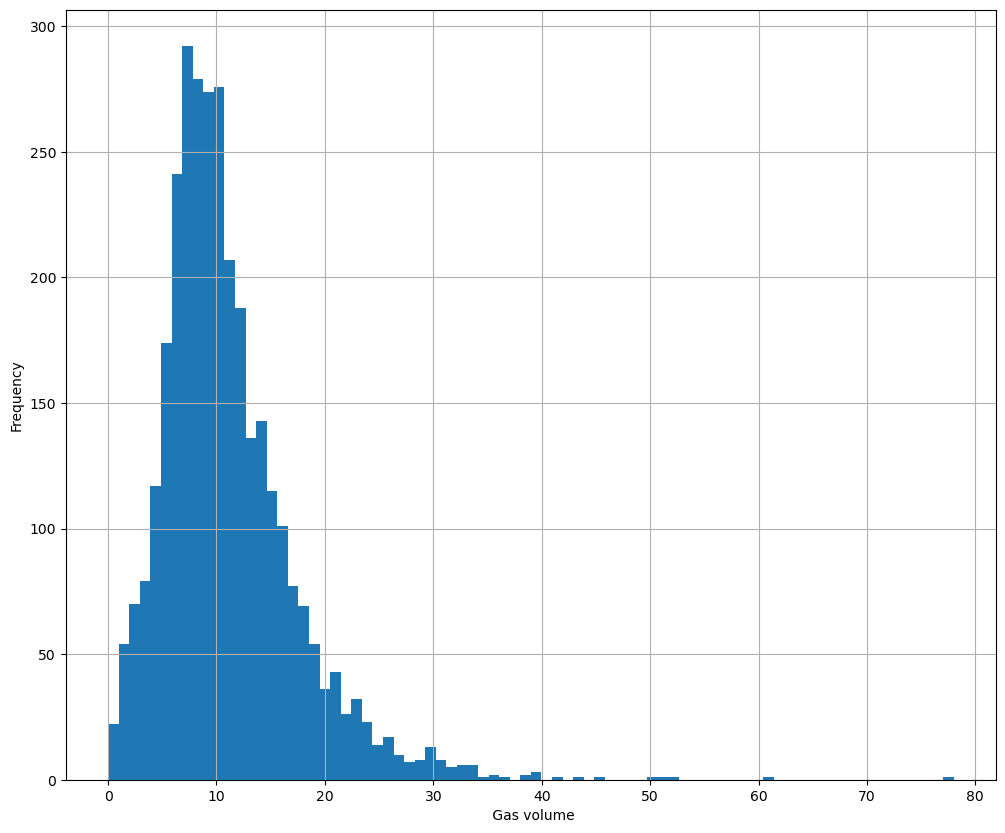

In [10]:
gas['gas1'].hist(bins = 80, figsize=(12,10))
plt.xlabel(' Gas volume')
plt.ylabel('Frequency')
plt.show()

The distribution is skewed to the right.

In [11]:
gas[gas['gas1'] <1].count()

key     23
gas1    23
dtype: int64

In [12]:
gas[gas['gas1'] > 30].count()

key     46
gas1    46
dtype: int64

Let's filter the data according to the interquantile scale and write a function to do this.

In [13]:
def subset_by_iqr(df, column):
    # Calculate Q1, Q2 and IQR
    q3 = df[column].quantile(0.99)
    filter = (df[column] <= q3)
    return df.loc[filter] 

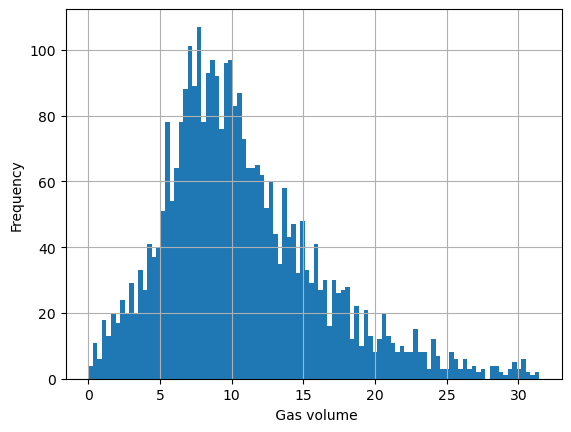

In [14]:
subset_by_iqr(gas, 'gas1')['gas1'].hist(bins = 100)
plt.xlabel(' Gas volume')
plt.ylabel('Frequency')
plt.show()

In [15]:
gas = subset_by_iqr(gas, 'gas1')

In [16]:
len(gas)/3239

0.9898116702686014

Filtered just over a percent of the data

### Bulk feeding data (volume)

In [17]:
bulk = pd.read_csv(path + 'data_bulk.csv')

In [18]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [19]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [20]:
bulk.isna().sum()/len(bulk)

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

In [21]:
bulk.duplicated().sum()

0

In the table with data on bulk material feeding, there are columns with gaps. Let's remove the columns with more than 30% missing data.

In [22]:
bulk = bulk[['key','Bulk 12','Bulk 14', 'Bulk 15']]

In [23]:
col = bulk.columns.drop('key',1)
col

Index(['Bulk 12', 'Bulk 14', 'Bulk 15'], dtype='object')

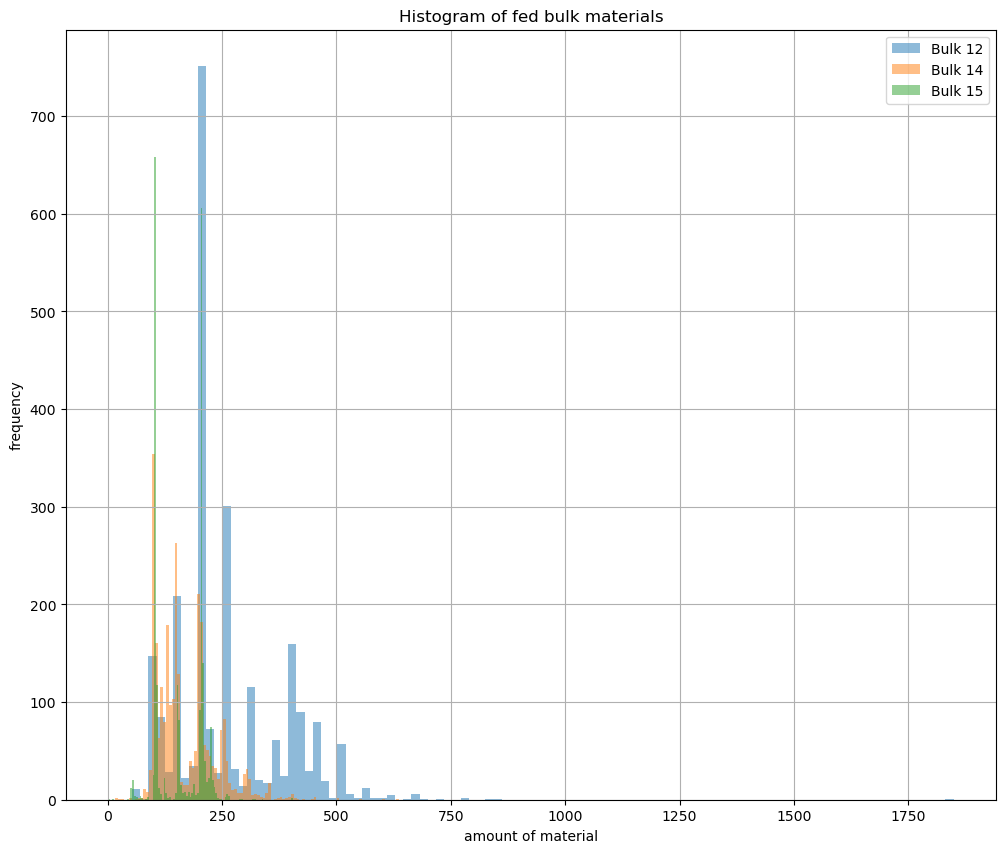

In [24]:
for cols in col:
    bulk[cols].hist(alpha = 0.5, figsize=(12,10), bins = 100, label = cols)
plt.title('Histogram of fed bulk materials')
plt.xlabel('amount of material')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

In [25]:
bulk['Bulk 12'][bulk['Bulk 12'] > 600]

11       618.0
207      666.0
303     1849.0
308      775.0
418      671.0
841      669.0
960      668.0
1005     647.0
1175     668.0
1240     609.0
1279     622.0
1410     774.0
1462     616.0
1591     667.0
1629     733.0
1755     833.0
1933     853.0
1976     620.0
2225     685.0
2825     624.0
Name: Bulk 12, dtype: float64

In [26]:
bulk['Bulk 12'][bulk['Bulk 12'] > 600] = np.nan

In [27]:
bulk['Bulk 12'][bulk['Bulk 12'] < 60]

1449    54.0
1533    55.0
1956    53.0
2070    54.0
2533    58.0
2535    58.0
2537    58.0
2724    58.0
2778    58.0
2962    54.0
3033    56.0
Name: Bulk 12, dtype: float64

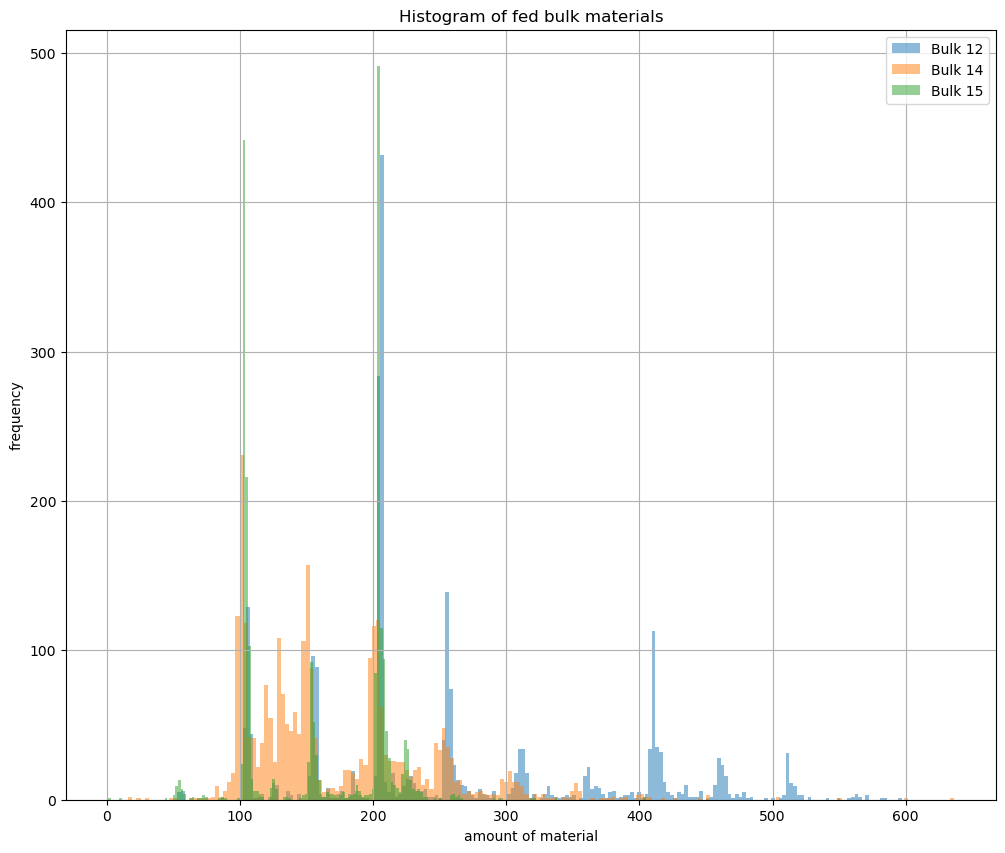

In [28]:
for cols in col:
    bulk[cols].hist(alpha = 0.5, figsize=(12,10), bins = 200, label = cols)
plt.title('Histogram of fed bulk materials')
plt.xlabel('amount of material')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

The distribution of the fed bulk materials is not uniform, there are peaks at volumes of bulk materials in the vicinity of 100 and 50.

In [29]:
len(bulk)

3129

In [30]:
bulk.isna().sum()

key          0
Bulk 12    699
Bulk 14    323
Bulk 15    881
dtype: int64

Replace the gaps in the data with the median.

In [31]:
bulk['Bulk 12'] = bulk['Bulk 12'].fillna(value = bulk['Bulk 12'].median())
bulk['Bulk 14'] = bulk['Bulk 14'].fillna(value = bulk['Bulk 12'].median())
bulk['Bulk 15'] = bulk['Bulk 15'].fillna(value = bulk['Bulk 12'].median())

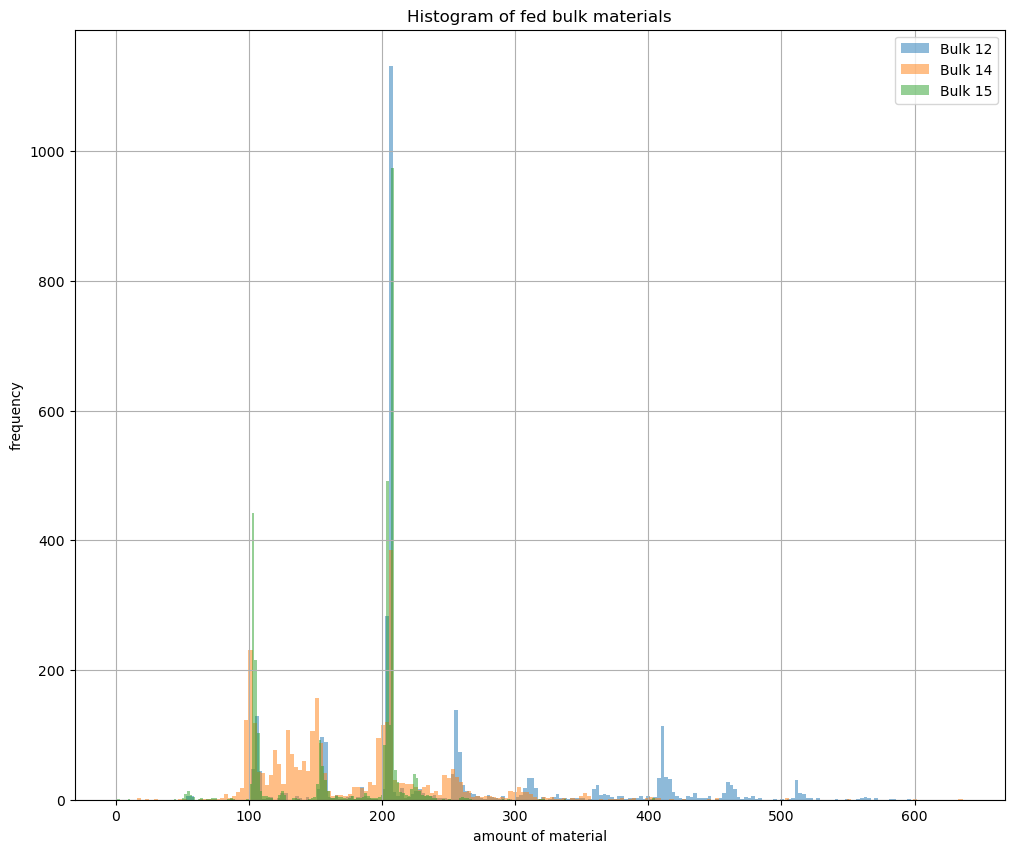

In [32]:
for cols in col:
    bulk[cols].hist(alpha = 0.5, figsize=(12,10), bins = 200, label = cols)
plt.title('Histogram of fed bulk materials')
plt.xlabel('amount of material')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

### Bulk feeding data (time)

In [33]:
bulk_time = pd.read_csv(path + 'data_bulk_time.csv')

In [34]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [35]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In the previous paragraph, we selected from the table only those columns that contain less than 30% missing data. Let's filter the data on the time of adding bulk materials in the same way.

In [36]:
bulk_time = bulk_time[['key','Bulk 12','Bulk 14', 'Bulk 15']]

In [37]:
bulk_time.dtypes

key         int64
Bulk 12    object
Bulk 14    object
Bulk 15    object
dtype: object

Change the data type to time

In [38]:
bulk_time['Bulk 12'] = pd.to_datetime(bulk_time['Bulk 12'],format='%Y-%m-%dT%H:%M:%S')
bulk_time['Bulk 14'] = pd.to_datetime(bulk_time['Bulk 14'],format='%Y-%m-%dT%H:%M:%S')
bulk_time['Bulk 15'] = pd.to_datetime(bulk_time['Bulk 15'],format='%Y-%m-%dT%H:%M:%S')

### Wire material data (volume)

In [39]:
wire = pd.read_csv(path + 'data_wire.csv')

In [40]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [42]:
wire.isna().sum()/len(wire)

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

In [43]:
wire.duplicated().sum()

0

In [44]:
col = wire.columns.drop('key',1)

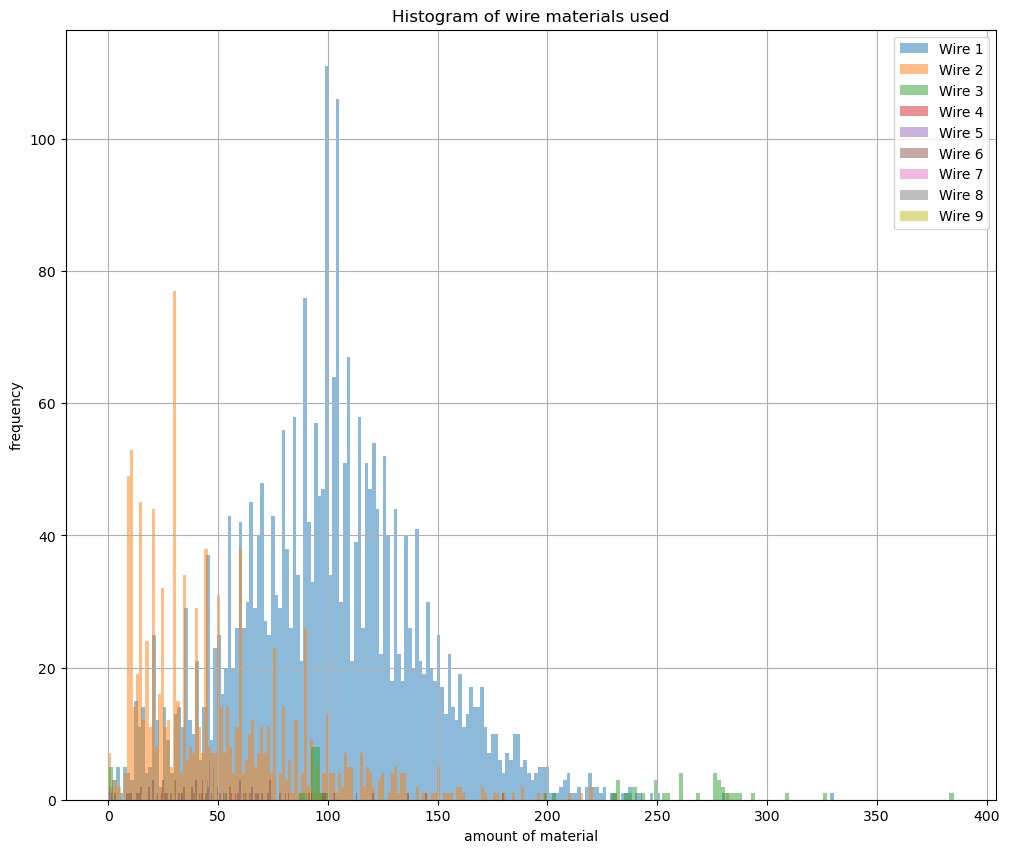

In [45]:
for cols in col:
    wire[cols].hist(alpha = 0.5, figsize=(12,10), bins = 200, label = cols)
plt.title('Histogram of wire materials used')
plt.xlabel('amount of material')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

In [46]:
wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

 Let's remove the columns that are missing more than 30% of the data. This leaves only the column `Wire 1`.

In [47]:
wire = wire[['key','Wire 1']]

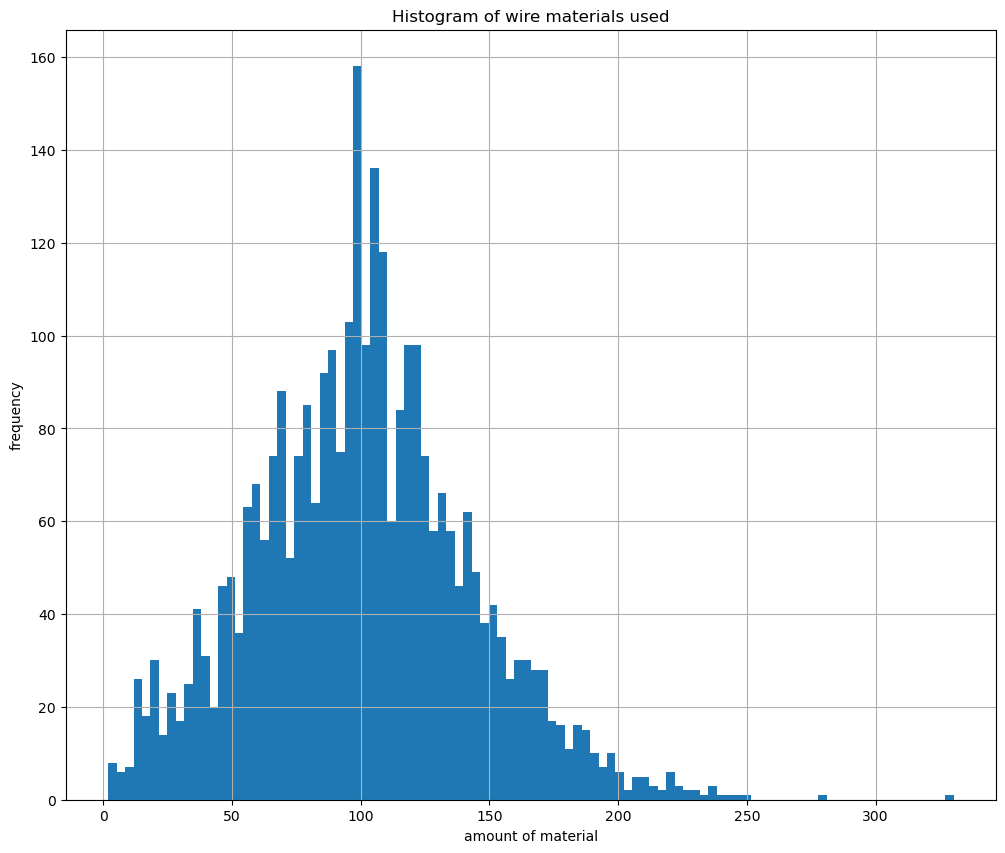

In [48]:
wire['Wire 1'].hist(bins = 100, figsize = (12,10))
plt.title('Histogram of wire materials used')
plt.xlabel('amount of material')
plt.ylabel('frequency')
plt.show()

In [49]:
wire[wire['Wire 1'] > 250]

,key,Wire 1
1392,1464,280.987214
1732,1821,330.314424


The distribution is normal, with a slight tail to the right side. Let us remove the values greater than 250.

In [50]:
wire = wire[wire['Wire 1'] < 250]

Let's replace the missing values with the average of the entire sample.

In [51]:
wire['Wire 1'] = wire['Wire 1'].fillna(value = wire['Wire 1'].median())

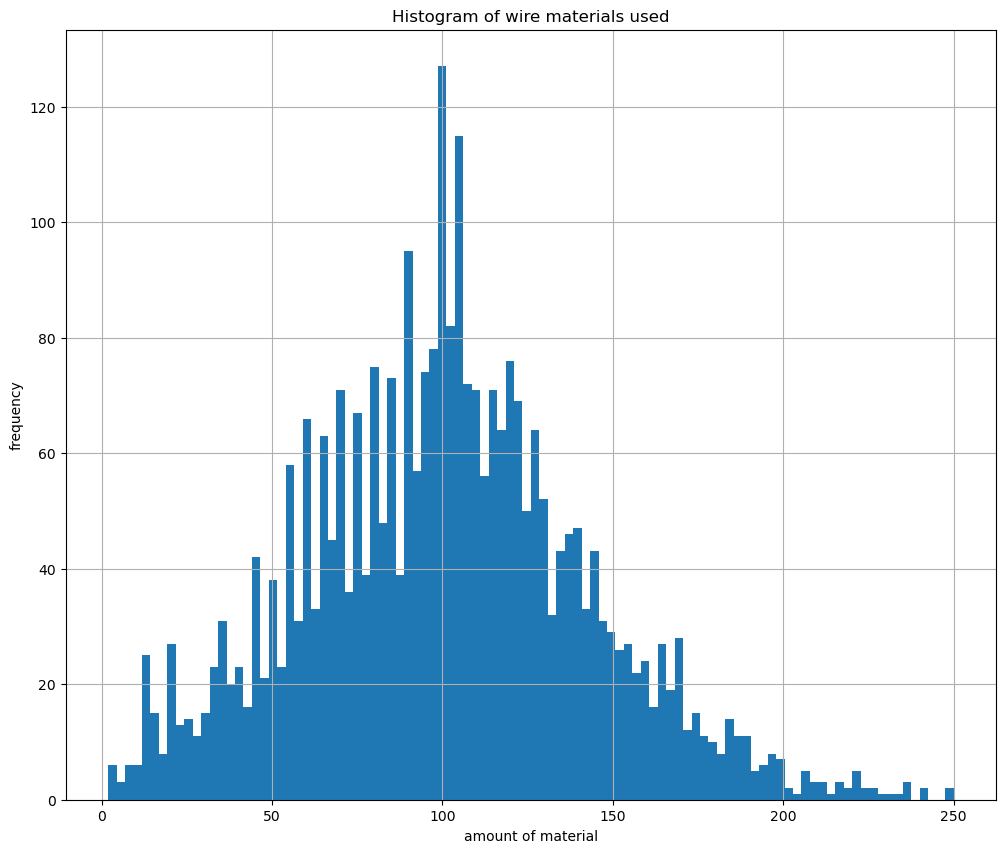

In [52]:
wire['Wire 1'].hist(bins = 100, figsize = (12,10))
plt.title('Histogram of wire materials used')
plt.xlabel('amount of material')
plt.ylabel('frequency')
plt.show()

### Wire material data (time)

In [53]:
wire_time = pd.read_csv(path + 'data_wire_time.csv')

In [54]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Due to the fact that we have removed columns with a large number of gaps, in the table with the amount of wire material, do the same with the data on the time of application of wire materials.

In [56]:
wire_time = wire_time[['key','Wire 1']]

In [57]:
wire_time.dropna(subset = ['Wire 1'], inplace = True)

In [58]:
wire_time.dtypes

key        int64
Wire 1    object
dtype: object

Change the data type to datetime

In [59]:
wire_time['Wire 1'] = pd.to_datetime(wire['Wire 1'],format='%Y-%m-%dT%H:%M:%S')

### Electrode data

In [60]:
arc = pd.read_csv(path + 'data_arc.csv')

In [61]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [62]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [63]:
arc.isna().sum()/len(arc)

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

Let's rename the columns and change the data type of the columns with time.

In [64]:
arc.columns = ['key', 'arc_heating_start','arc_heating_end', 'active_power', 'reactive_power']
arc['arc_heating_start'] = pd.to_datetime(arc['arc_heating_start'],format='%Y-%m-%dT%H:%M:%S')
arc['arc_heating_end'] = pd.to_datetime(arc['arc_heating_end'],format='%Y-%m-%dT%H:%M:%S')

In [65]:
arc.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


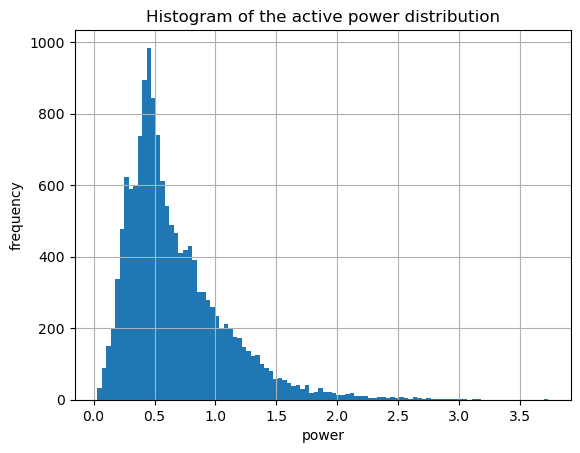

In [66]:
arc['active_power'].hist(bins = 100)
plt.title('Histogram of the active power distribution')
plt.xlabel('power')
plt.ylabel('frequency')
plt.show()

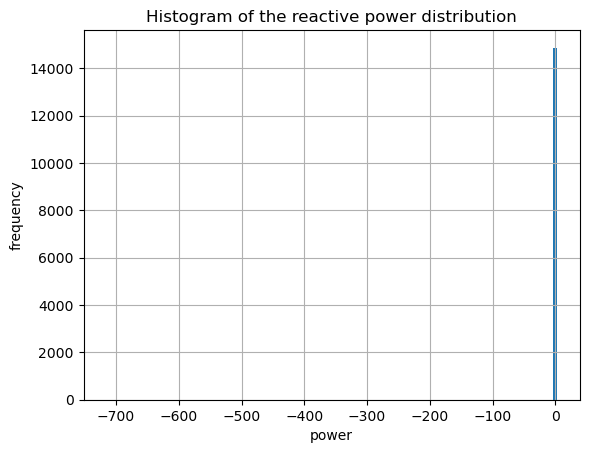

In [67]:
arc['reactive_power'].hist(bins = 100)
plt.title('Histogram of the reactive power distribution')
plt.xlabel('power')
plt.ylabel('frequency')
plt.show()

The reactive power cannot be negative. 

In [68]:
arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [69]:
arc[arc['reactive_power'] < 0]

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [70]:
arc[arc['key'] == 2116]

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [71]:
arc = arc[arc['key'] != 2116 ]

In [72]:
arc.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


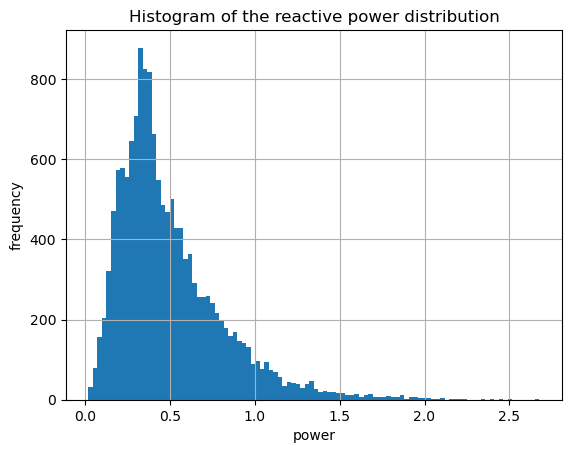

In [73]:
arc['reactive_power'].hist(bins = 100)
plt.title('Histogram of the reactive power distribution')
plt.xlabel('power')
plt.ylabel('frequency')
plt.show()

Let's calculate how long it takes to warm up the arc as a whole for all iterations.

In [74]:
def time_diff(df):
    df['time_diff'] = df['arc_heating_end'] - df['arc_heating_start']
    
    return df['time_diff']

In [75]:
arc.dtypes

key                           int64
arc_heating_start    datetime64[ns]
arc_heating_end      datetime64[ns]
active_power                float64
reactive_power              float64
dtype: object

In [76]:
arc['time_diff'] = arc.apply(time_diff, axis = 1)

In [77]:
arc.head(1)

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48


Let's convert the value of the interval between the beginning and the end of the warm-up in seconds, sum up the values of active and reactive powers and add to the table the time of the beginning and the end of the arc warm-up.

In [78]:
arc['time_diff'] = arc['time_diff'] / np.timedelta64(1, 's')

In [79]:
arc.head(1)

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0


In [80]:
arc_grouped = arc.groupby('key')[['active_power', 'reactive_power','time_diff']].agg('sum').reset_index()

In [81]:
arc_grouped_end_time = arc.groupby('key')['arc_heating_end'].agg('max')

In [82]:
arc_grouped_start_time = arc.groupby('key')['arc_heating_start'].agg('min')

In [83]:
arc_grouped = arc_grouped.merge(arc_grouped_start_time, on='key', how='left')

In [84]:
arc_grouped = arc_grouped.merge(arc_grouped_end_time, on='key', how='left')

In [85]:
arc_grouped.head()

,key,active_power,reactive_power,time_diff,arc_heating_start,arc_heating_end
0,1,4.878147,3.183241,1098.0,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,3.052598,1.998112,811.0,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,2.525882,1.599076,655.0,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,3.209250,2.060298,741.0,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,3.347173,2.252643,869.0,2019-05-03 13:11:13,2019-05-03 13:33:55


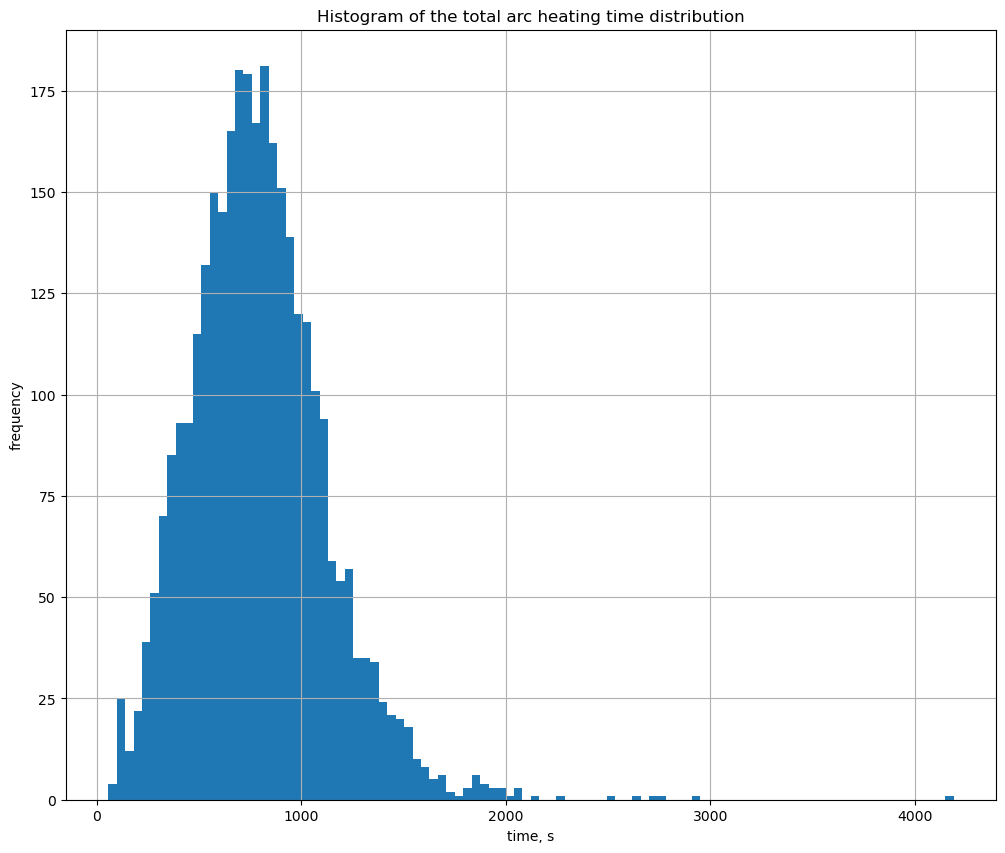

In [86]:
arc_grouped['time_diff'].hist(bins = 100, figsize = (12,10))
plt.title('Histogram of the total arc heating time distribution')
plt.xlabel('time, s')
plt.ylabel('frequency')
plt.show()

Let's remove the data with an abnormally long heating of the alloy.

In [87]:
arc_grouped[arc_grouped['time_diff'] > 2100]

,key,active_power,reactive_power,time_diff,arc_heating_start,arc_heating_end
42,45,9.184464,6.563533,2136.0,2019-05-04 23:02:37,2019-05-05 00:23:05
43,46,12.361625,8.369891,2919.0,2019-05-04 23:46:31,2019-05-05 03:08:57
317,322,9.521275,8.020549,2658.0,2019-05-15 09:06:35,2019-05-15 10:57:42
799,813,8.070847,8.876344,2247.0,2019-06-02 12:39:59,2019-06-02 13:36:40
1496,1513,9.910345,8.135789,2526.0,2019-06-26 19:55:50,2019-06-26 23:03:03
1672,1689,17.496497,12.587990,4189.0,2019-07-02 15:25:34,2019-07-02 21:56:59
1863,1880,11.387710,9.866436,2755.0,2019-07-09 05:54:14,2019-07-09 09:10:30
2089,2108,10.426942,10.072821,2739.0,2019-07-23 14:05:57,2019-07-23 19:55:39


In [88]:
arc_grouped = arc_grouped[arc_grouped['time_diff'] < 2100]

### Temperature measurement results

In [89]:
temp = pd.read_csv(path + 'data_temp.csv')

In [90]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [91]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [92]:
temp.columns = ['key', 'measurement_time','temperature']

In [93]:
temp['measurement_time'] = pd.to_datetime(temp['measurement_time'],format='%Y-%m-%dT%H:%M:%S')

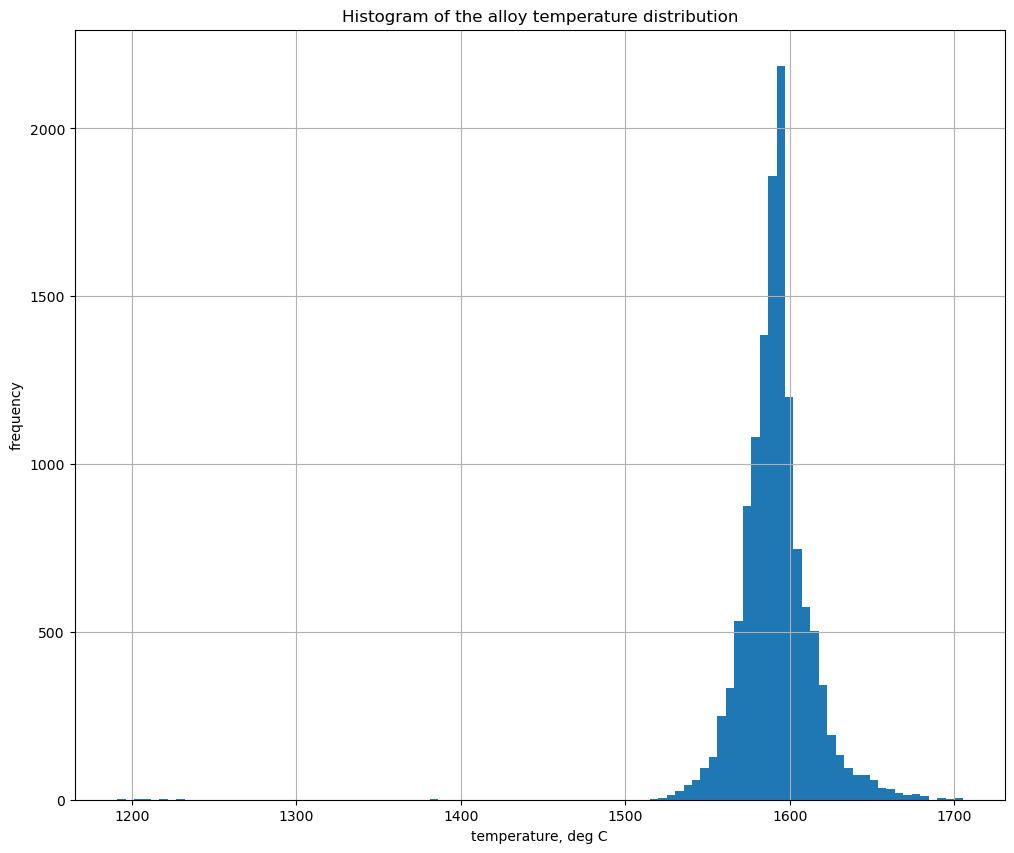

In [94]:
temp['temperature'].hist(bins = 100, figsize = (12,10))
plt.title('Histogram of the alloy temperature distribution')
plt.xlabel('temperature, deg C')
plt.ylabel('frequency')
plt.show()

In [95]:
temp.describe()

,key,temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Let's remove abnormal temperatures below 1550 degrees and above 1690 degrees.

In [96]:
temp = temp[temp['temperature'] > 1500]

In [97]:
temp = temp[temp['temperature'] < 1690]

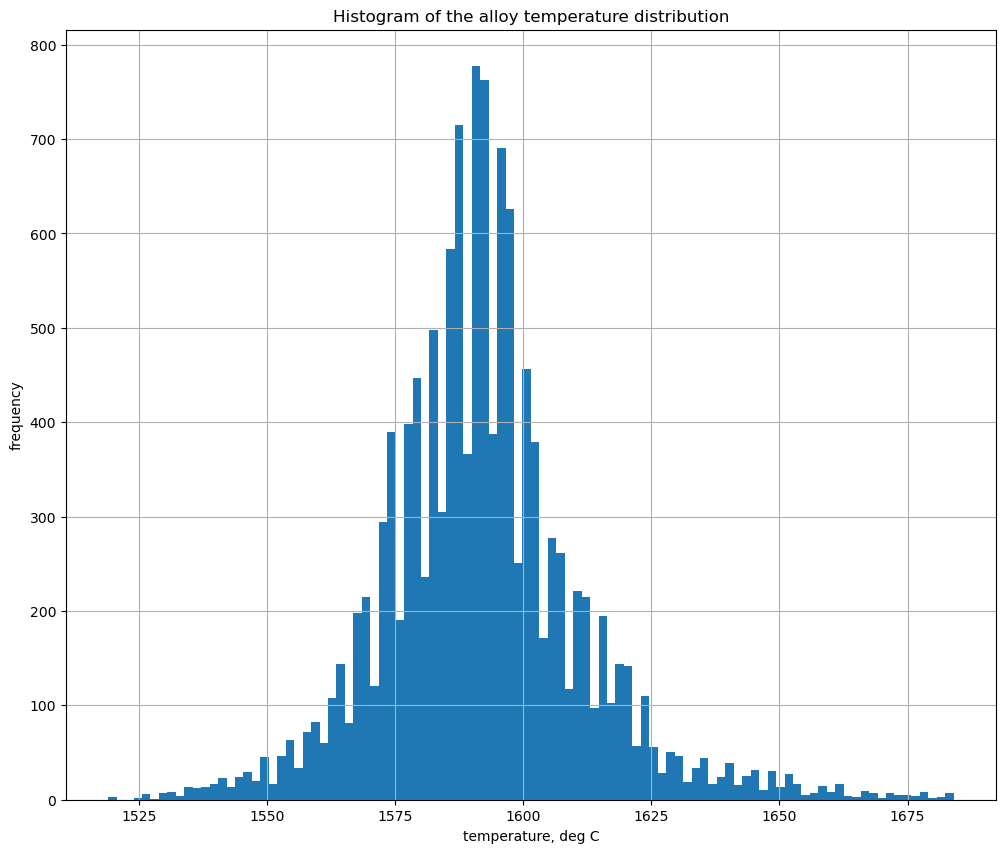

In [98]:
temp['temperature'].hist(bins = 100, figsize = (12,10))
plt.title('Histogram of the alloy temperature distribution')
plt.xlabel('temperature, deg C')
plt.ylabel('frequency')
plt.show()

In [99]:
arc.head(1)

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0


In [100]:
temp_stop = temp.groupby('key')['measurement_time'].agg('max').reset_index()
temp_stop.columns = ['key','measurement_time']
temp_stop.head()

,key,measurement_time
0,1,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01


In [101]:
temp_stop = temp_stop.merge(temp, on='measurement_time', how='left').drop('key_y',axis = 1)

In [102]:
temp_stop.columns = ['key', 'last_measurement_time', 'last_temp']

In [103]:
temp_stop.head()

,key,last_measurement_time,last_temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


In [104]:
temp_start = temp.groupby('key')['measurement_time'].agg('min').reset_index()
temp_start.columns = ['key','measurement_time']
temp_start.head()

,key,measurement_time
0,1,2019-05-03 11:16:18
1,2,2019-05-03 11:37:27
2,3,2019-05-03 12:13:17
3,4,2019-05-03 12:52:57
4,5,2019-05-03 13:23:19


In [105]:
temp_start = temp_start.merge(temp, on='measurement_time', how='left').drop('key_y',1)

/tmp/ipykernel_2897/38187193.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp_start = temp_start.merge(temp, on='measurement_time', how='left').drop('key_y',1)


In [106]:
temp_start.columns = ['key', 'first_measurement_time', 'first_temp']

In [107]:
temp_start.head()

,key,first_measurement_time,first_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


In [108]:
len(temp_stop), len(arc_grouped), len(gas), len(wire),len(wire_time), len(bulk),  len(bulk_time)

(3215, 3205, 3206, 3053, 3055, 3129, 3129)

In [109]:
temp_stop = temp_stop.merge(temp_start, on='key', how='left')

In [110]:
temp_stop = temp_stop.merge(arc_grouped, on='key', how='left')

In [111]:
temp_stop = temp_stop.merge(gas, on='key', how='left')

In [112]:
temp_stop = temp_stop.merge(wire, on='key', how='left')

In [113]:
temp_stop = temp_stop.merge(wire_time, on='key', how='left')

In [114]:
temp_stop = temp_stop.merge(bulk, on='key', how='left')

In [115]:
temp_stop = temp_stop.merge(bulk_time, on='key', how='left')

In [116]:
temp_stop.columns

Index(['key', 'last_measurement_time', 'last_temp', 'first_measurement_time',
       'first_temp', 'active_power', 'reactive_power', 'time_diff',
       'arc_heating_start', 'arc_heating_end', 'gas1', 'Wire 1_x', 'Wire 1_y',
       'Bulk 12_x', 'Bulk 14_x', 'Bulk 15_x', 'Bulk 12_y', 'Bulk 14_y',
       'Bulk 15_y'],
      dtype='object')

In [117]:
temp_stop.columns = ['key', 'last_measurement_time', 'last_temp', 'first_measurement_time',
       'first_temp', 'active_power', 'reactive_power', 'time_diff',
       'arc_heating_start', 'arc_heating_end', 'gas1', 'wire_1', 'wire_1_time',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_12_time', 'bulk_14_time',
       'bulk_15_time']

In [118]:
temp_stop.head()

,key,last_measurement_time,last_temp,first_measurement_time,first_temp,active_power,reactive_power,time_diff,arc_heating_start,arc_heating_end,gas1,wire_1,wire_1_time,bulk_12,bulk_14,bulk_15,bulk_12_time,bulk_14_time,bulk_15_time
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,1098.0,2019-05-03 11:02:14,2019-05-03 11:28:37,29.749986,60.059998,1970-01-01 00:00:00.000000060,206.0,150.0,154.0,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,811.0,2019-05-03 11:34:14,2019-05-03 11:53:18,12.555561,96.052315,1970-01-01 00:00:00.000000096,206.0,149.0,154.0,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,655.0,2019-05-03 12:06:54,2019-05-03 12:32:19,28.554793,91.160157,1970-01-01 00:00:00.000000091,205.0,152.0,153.0,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,741.0,2019-05-03 12:39:37,2019-05-03 12:57:50,18.841219,89.063515,1970-01-01 00:00:00.000000089,207.0,153.0,154.0,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,869.0,2019-05-03 13:11:13,2019-05-03 13:33:55,5.413692,89.238236,1970-01-01 00:00:00.000000089,203.0,151.0,152.0,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56


Check if the temperature provided in the `temp` file is the last temperature and if any additives have been entered since the last temperature measurement.

In [119]:
df = temp_stop.copy()

In [120]:
df.head()

,key,last_measurement_time,last_temp,first_measurement_time,first_temp,active_power,reactive_power,time_diff,arc_heating_start,arc_heating_end,gas1,wire_1,wire_1_time,bulk_12,bulk_14,bulk_15,bulk_12_time,bulk_14_time,bulk_15_time
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,1098.0,2019-05-03 11:02:14,2019-05-03 11:28:37,29.749986,60.059998,1970-01-01 00:00:00.000000060,206.0,150.0,154.0,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,811.0,2019-05-03 11:34:14,2019-05-03 11:53:18,12.555561,96.052315,1970-01-01 00:00:00.000000096,206.0,149.0,154.0,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,655.0,2019-05-03 12:06:54,2019-05-03 12:32:19,28.554793,91.160157,1970-01-01 00:00:00.000000091,205.0,152.0,153.0,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,741.0,2019-05-03 12:39:37,2019-05-03 12:57:50,18.841219,89.063515,1970-01-01 00:00:00.000000089,207.0,153.0,154.0,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,869.0,2019-05-03 13:11:13,2019-05-03 13:33:55,5.413692,89.238236,1970-01-01 00:00:00.000000089,203.0,151.0,152.0,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56


In [121]:
def flag(row):
    if row['arc_heating_end'] > row['last_measurement_time']:
        return 0
    elif row['wire_1_time'] > row['last_measurement_time']:
        return 0
    elif  row['bulk_12_time'] > row['last_measurement_time']:
        return 0
    elif  row['bulk_14_time'] > row['last_measurement_time']:
        return 0
    elif  row['bulk_15_time'] > row['last_measurement_time']:
        return 0
    else:
        return 1
       
    return row['flag']


In [122]:
df['flag'] = df.apply(flag, axis = 1)

In [123]:
df.head()

,key,last_measurement_time,last_temp,first_measurement_time,first_temp,active_power,reactive_power,time_diff,arc_heating_start,arc_heating_end,gas1,wire_1,wire_1_time,bulk_12,bulk_14,bulk_15,bulk_12_time,bulk_14_time,bulk_15_time,flag
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,1098.0,2019-05-03 11:02:14,2019-05-03 11:28:37,29.749986,60.059998,1970-01-01 00:00:00.000000060,206.0,150.0,154.0,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,1
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,811.0,2019-05-03 11:34:14,2019-05-03 11:53:18,12.555561,96.052315,1970-01-01 00:00:00.000000096,206.0,149.0,154.0,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,1
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,655.0,2019-05-03 12:06:54,2019-05-03 12:32:19,28.554793,91.160157,1970-01-01 00:00:00.000000091,205.0,152.0,153.0,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,1
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,741.0,2019-05-03 12:39:37,2019-05-03 12:57:50,18.841219,89.063515,1970-01-01 00:00:00.000000089,207.0,153.0,154.0,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,1
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,869.0,2019-05-03 13:11:13,2019-05-03 13:33:55,5.413692,89.238236,1970-01-01 00:00:00.000000089,203.0,151.0,152.0,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,1


In [124]:
len(df[df['flag'] == 1])/3215

0.7312597200622084

In [125]:
df = df[df['flag'] == 1]

In [126]:
df.head()

,key,last_measurement_time,last_temp,first_measurement_time,first_temp,active_power,reactive_power,time_diff,arc_heating_start,arc_heating_end,gas1,wire_1,wire_1_time,bulk_12,bulk_14,bulk_15,bulk_12_time,bulk_14_time,bulk_15_time,flag
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.878147,3.183241,1098.0,2019-05-03 11:02:14,2019-05-03 11:28:37,29.749986,60.059998,1970-01-01 00:00:00.000000060,206.0,150.0,154.0,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,1
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.052598,1.998112,811.0,2019-05-03 11:34:14,2019-05-03 11:53:18,12.555561,96.052315,1970-01-01 00:00:00.000000096,206.0,149.0,154.0,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,1
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,2.525882,1.599076,655.0,2019-05-03 12:06:54,2019-05-03 12:32:19,28.554793,91.160157,1970-01-01 00:00:00.000000091,205.0,152.0,153.0,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,1
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,3.209250,2.060298,741.0,2019-05-03 12:39:37,2019-05-03 12:57:50,18.841219,89.063515,1970-01-01 00:00:00.000000089,207.0,153.0,154.0,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,1
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,3.347173,2.252643,869.0,2019-05-03 13:11:13,2019-05-03 13:33:55,5.413692,89.238236,1970-01-01 00:00:00.000000089,203.0,151.0,152.0,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,1


There is 73% of the data left of the original volume.

### Conclusions  
Preprocessing of the provided data was done:
* The columns have been renamed.
* The data types have been aligned.
* It was found that some columns in the loose and wire data files were missing more than 70% of the values. It was decided to remove the columns with a large number of omissions. Further, if there are not enough signs to get the required MAE metric value, it will be possible to return to this issue. The remaining gaps in the columns with bulk data were replaced by the median, the gaps in the columns with wire data were replaced by the mean value.
* Electrode data are filtered by heating time duration.
* Active and reactive power data are summed over the `key` field.
* The columns with the start and end of arc heating are separated.
* The data files are combined into one table by the `key' field.
* A check has been made to ensure that the value of the last temperature measurement is the end of the process.

Let's check the signs for multicollinearity.

In [127]:
len(df)

2351

In [128]:
df.columns

Index(['key', 'last_measurement_time', 'last_temp', 'first_measurement_time',
       'first_temp', 'active_power', 'reactive_power', 'time_diff',
       'arc_heating_start', 'arc_heating_end', 'gas1', 'wire_1', 'wire_1_time',
       'bulk_12', 'bulk_14', 'bulk_15', 'bulk_12_time', 'bulk_14_time',
       'bulk_15_time', 'flag'],
      dtype='object')

In [129]:
df_col = ['last_temp','first_temp', 'active_power', 'reactive_power', 'gas1', 'wire_1', 'bulk_12', 'bulk_14', 'bulk_15']

In [130]:
df = df[df_col]

In [131]:
df.isna().sum()

last_temp           0
first_temp          0
active_power       11
reactive_power     11
gas1               31
wire_1            118
bulk_12            64
bulk_14            64
bulk_15            64
dtype: int64

In [132]:
df = df.dropna()

In [133]:
len(df)

2160

Let's perform a test for multicollinearity.

In [134]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [135]:
vif_data

,feature,VIF
0,last_temp,9931.370074
1,first_temp,9686.318550
2,active_power,91.363765
3,reactive_power,75.449785
4,gas1,6.455521
5,wire_1,7.922125
6,bulk_12,10.080185
7,bulk_14,11.845494
8,bulk_15,16.849626


The test revealed that the attributes `active_power` and `reactive power` are highly collinear. Let's remove the sign `reactive_power`.

In [136]:
df = df.drop('reactive_power', axis = 1).reset_index(drop=True)

In [137]:
df.head()

,last_temp,first_temp,active_power,gas1,wire_1,bulk_12,bulk_14,bulk_15
0,1613.0,1571.0,4.878147,29.749986,60.059998,206.0,150.0,154.0
1,1602.0,1581.0,3.052598,12.555561,96.052315,206.0,149.0,154.0
2,1599.0,1596.0,2.525882,28.554793,91.160157,205.0,152.0,153.0
3,1625.0,1601.0,3.209250,18.841219,89.063515,207.0,153.0,154.0
4,1602.0,1576.0,3.347173,5.413692,89.238236,203.0,151.0,152.0


## Modeling

### Linear regression

We leave 20% of all data for the test. Since we plan to use cross-validation, we divide the sample into training and test samples.

In [138]:
test = df.sample(frac=0.2,random_state=12345).copy()

In [139]:
X_test = test.drop(['last_temp'], axis = 1)
y_test = test['last_temp']

In [140]:
train_full = df[~df.index.isin(test.index)].copy()

In [141]:
X_full = train_full.drop(['last_temp'], axis = 1)
y_full = train_full['last_temp']

In [142]:
X_full.columns

Index(['first_temp', 'active_power', 'gas1', 'wire_1', 'bulk_12', 'bulk_14',
       'bulk_15'],
      dtype='object')

In [143]:
def linreg(X,y):
   
    model = LinearRegression()
    model.fit(X,y)
    result = cross_val_score(model,X,y,cv=3,scoring='neg_mean_absolute_error').mean() * (-1)
    return model, result

In [144]:
linreg_model, linreg_score = linreg(X_full,y_full)
linreg_score

6.566567923601812

In [145]:
linreg_test_score = mean_absolute_error(y_test, linreg_model.predict(X_test))
linreg_test_score

6.235409865282729

In [146]:
pred = linreg_model.predict(X_test)

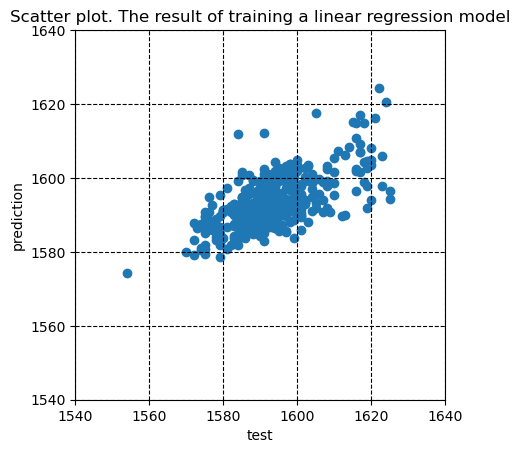

In [147]:
fig, ax = plt.subplots()
plt.scatter(y_test, pred)
plt.title('Scatter plot. The result of training a linear regression model')
plt.xlim([1540,1640])
plt.ylim([1540,1640])
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.xlabel('test')
plt.ylabel('prediction')
plt.show()

The MAE of the linear regression model on the test sample was 6.24.  
The MAE for cross-validation was 6.57.  
At the same time, the scatter diagram reflects that the scatter of data-prediction values is quite large.

### Random Forest

In [148]:
def forestreg(X,y):
    model = RandomForestRegressor()
    hyperparams = [{'criterion':['squared_error'],
                 'max_depth':[x for x in range(5, 10, 1)],
                 'n_estimators':[x for x in range(100, 601, 50)], 
                 'random_state':[12345]}]
    grid_search = GridSearchCV(model, hyperparams, scoring='neg_mean_absolute_error', cv=3)
    grid_search.fit(X, y)
    best_parameters = grid_search.best_params_
    mean = grid_search.cv_results_['mean_test_score']
    result = (max(mean)*(-1))
        
            
    return grid_search, best_parameters, result

In [149]:
forest_model, forest_parameters, result = forestreg(X_full,y_full)
forest_parameters, result

({'criterion': 'squared_error',
  'max_depth': 8,
  'n_estimators': 500,
  'random_state': 12345},
 6.472902601391881)

In [150]:
forest_test_score = mean_absolute_error(y_test, forest_model.predict(X_test))
forest_test_score

6.030589351522609

In [151]:
forest_pred =  forest_model.predict(X_test)

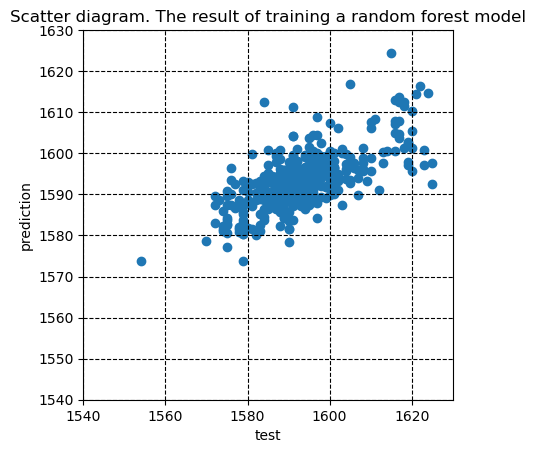

In [152]:
fig, ax = plt.subplots()
plt.scatter(y_test, forest_pred)
plt.title('Scatter diagram. The result of training a random forest model')
plt.xlim([1540,1630])
plt.ylim([1540,1630])
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.xlabel('test')
plt.ylabel('prediction')
plt.show()

The MAE of the Random Forest model on the test sample was 6.03.  
The MAE for cross-validation was 6.47.  
The scatter plot reflects that the scatter of data-prediction values is also quite large, but better than when using a linear regression model.

### CatBoost

In [153]:
def catboost(X,y):
    model_cb = cb.CatBoostRegressor(verbose=1000)
    param_set = {'learning_rate': [0.01, 0.1],
                 'depth': [4,6],
                 'l2_leaf_reg': [2,3,4]}
    gsearch = GridSearchCV(model_cb, param_grid=param_set, scoring= 'neg_mean_absolute_error', n_jobs=-1, cv=3, verbose = 1)
    gsearch.fit(X,y)
    return gsearch, gsearch.best_params_

In [154]:
cb_model, cb_params = catboost(X_full, y_full)
cb_params

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0:	learn: 11.1302869	total: 49.9ms	remaining: 49.8s
999:	learn: 6.8491701	total: 1.47s	remaining: 0us


{'depth': 6, 'l2_leaf_reg': 2, 'learning_rate': 0.01}

In [155]:
max(cb_model.cv_results_['mean_test_score'])*(-1)

6.338991118146391

In [156]:
cb_test_score = mean_absolute_error(y_test, cb_model.predict(X_test))
cb_test_score

5.901690308968587

In [157]:
cb_pred = cb_model.predict(X_test)

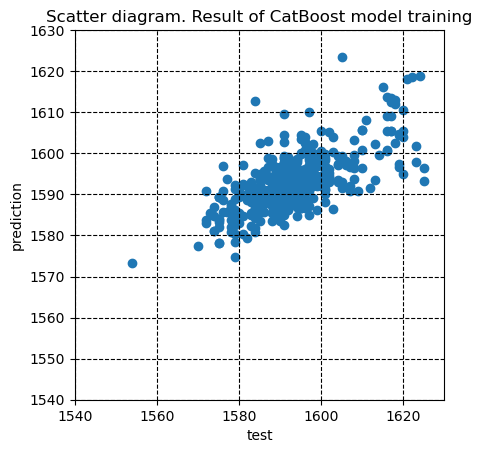

In [158]:
fig, ax = plt.subplots()
plt.scatter(y_test, cb_pred)
plt.title('Scatter diagram. Result of CatBoost model training')
plt.xlim([1540,1630])
plt.ylim([1540,1630])
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.grid(visible=True, which='major', color='k', linestyle='--')
plt.xlabel('test')
plt.ylabel('prediction')
plt.show()

Let's assess the importance of the features.

In [159]:
model = cb.CatBoostRegressor(l2_leaf_reg=2,
                          learning_rate=0.01,
                          depth=6,
                          verbose =1000)
model.fit(X_full, y_full)

0:	learn: 11.1302869	total: 926us	remaining: 926ms
999:	learn: 6.8491701	total: 763ms	remaining: 0us


Text(0.5, 1.0, 'Feature Importance')

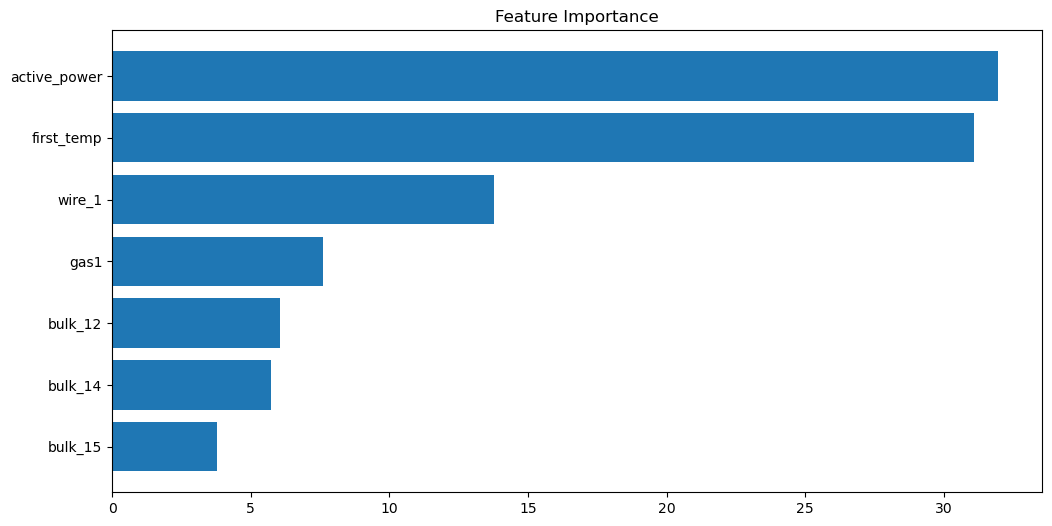

In [160]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

The most important features are active power, initial temperature, wire materials and gas volume, followed by bulk materials. Since we got a high metric value, let's leave it as it is.

The MAE of the CatBoost model on the test sample was 5.90.  
The MAE for cross-validation was 6.34.  


In [161]:
d = {'Regressor': ['Linear Regression', 'Random Forest Regressor','CatBoost regressor'], 
     'MAE': [mean_absolute_error(y_test, linreg_model.predict(X_test)), 
             mean_absolute_error(y_test, forest_model.predict(X_test)), 
             mean_absolute_error(y_test, cb_model.predict(X_test))]}
result_table = pd.DataFrame(data=d)
 
result_table

,Regressor,MAE
0,Linear Regression,6.235410
1,Random Forest Regressor,6.030589
2,CatBoost regressor,5.901690


### Conclusion

* The data were split into two samples (80% training sample, 20% test sample)
* Three models were trained using cross validation on three fouls: linear regression, random forest, and CatBoost.
* The best result on the test sample was shown by the CatBoost model with the metric MAE = 5.90. 